# Homework 3: Sampling and Particle Filter
Due: April 30, 2025

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Image loading packages
from PIL import Image

## Problem 1: Image Probability Density Function

![Lincoln](lincoln.jpg)

Image shape: (250, 250)


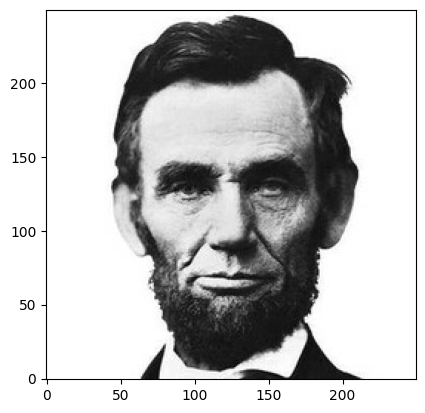

In [34]:
# Read the image as a PIL image
def read_image(path: str):
    with open(path, 'rb') as f:
        img = Image.open(f)
        img.load()
    # Convert to numpy array
    img = np.array(img)
    img = np.flip(img, axis=0)
    return img
img = read_image('lincoln.jpg')
plt.imshow(img, cmap='gray', origin='lower')
print(f"Image shape: {img.shape}")

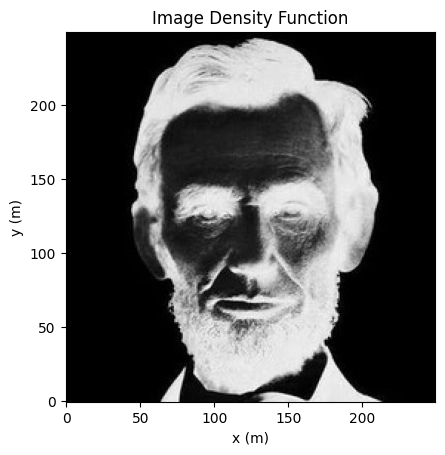

In [35]:
# Convert to Continuous Probability Density Function (PDF) 
# over a space of 1 meter by 1 meter.

# the x coordinates of image pixels in the new space
xgrids = np.linspace(0.0, 1.0, img.shape[0])
dx = xgrids[1] - xgrids[0]
# the y coordinates of image pixels in the new space
ygrids = np.linspace(0.0, 1.0, img.shape[1])
dy = ygrids[1] - ygrids[0]

# we now invert dark and light pixel density and normalize the density values so it is a valid probability distribution
density_array = 255.0 - img  # we want higher density at darker regions
density_array /= np.sum(density_array) * dx * dy  # so the integral is 1


def image_density(s):
    """ Continuous density function based on the image
    Inputs:
        s - a numpy array containing the (x,y) coordinate within the 1m-by-1m space
    Return:
        val - the density value at s
    """
    s_x, s_y = s

    # Find the pixel closest to s in the 1-by-1 space
    # Note that in image the first pixel coordinate correspond to the y-axis in the 1-by-1 space
    pixel_idx_y = np.argmin(np.abs(xgrids - s_x))
    pixel_idx_x = np.argmin(np.abs(ygrids - s_y))

    # the density at s is the same as the closest pixel density
    val = density_array[pixel_idx_x, pixel_idx_y]

    return val

# Show the probability density function
fig, ax = plt.subplots()
ax.imshow(density_array, cmap='gray', origin='lower')
ax.set_title('Image Density Function')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
plt.show()

## Importance Sampling

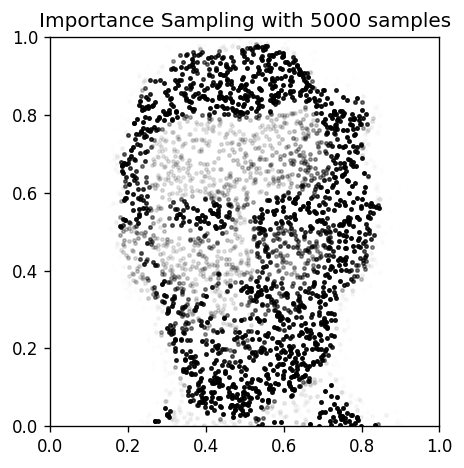

In [36]:
num_samples = 5000
samples = np.random.uniform(low=0.0, high=1.0, size=(num_samples, 2))
sample_weights = np.zeros(num_samples)

for i in range(num_samples):
    sample_weights[i] = image_density(samples[i])

# for visualization purpose, we adjust the weights such that the maximum weight is 1.0
# (matplotlib only accepts values between 0.0 to 1.0 as the opacity value)
# (this is not the same as normalization in importance sampling or rejection sampling)
sample_weights /= np.max(sample_weights)

# now we visualize the weighted samples
fig, ax = fig, ax = plt.subplots(
    1, 1, figsize=(4, 4), dpi=120, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)

for sample, weight in zip(samples, sample_weights):
    ax.plot(sample[0], sample[1], linestyle='', marker='o',
            markersize=2, color='k', alpha=weight)
plt.title(f"Importance Sampling with {num_samples} samples")
plt.savefig('importance_sampling.png', dpi=120)
plt.show()

## Rejection Sampling
Sample 5000 points from the image-based probability distribution. Create 2 different proposal distributions

Uniform Sampling efficiency: 37.66%
Normal Sampling efficiency: 35.79%


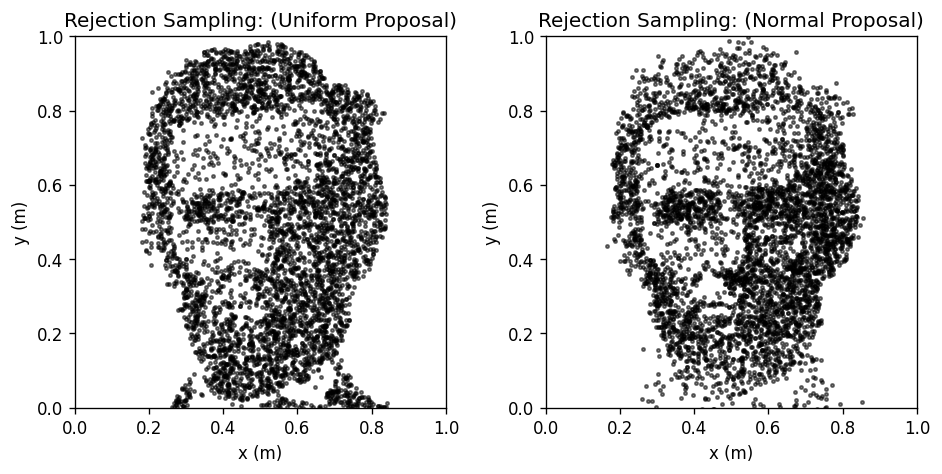

In [37]:
# 1st proposal distribution: Uniform distribution
# 2nd proposal distribution: Normal distribution

def rejection_sampling(proposal_id, target_pdf, proposal_pdf, proposal_sampler, M, n_samples):
    """
    Perform rejection sampling to generate samples from target distribution.
    
    Parameters:
    - proposal_id: ID of the proposal distribution (1 for Uniform, 2 for Normal)
    - target_pdf: Function that computes the target probability density at x
    - proposal_pdf: Function that computes the proposal probability density at x
    - proposal_sampler: Function that generates samples from proposal distribution
    - M: Scaling factor such that M * proposal_pdf(x) >= target_pdf(x) for all x
    - n_samples: Number of samples to generate
    
    Returns:
    - Array of accepted samples from the target distribution
    """
    samples = []
    total_iterations = 0
    while len(samples) < n_samples:
        # Generate sample from proposal distribution
        x = proposal_sampler()
        # Generate uniform random number
        u = np.random.uniform(0, 1)
        # Calculate acceptance ratio
        acceptance_ratio = target_pdf(x) / (M * proposal_pdf(x))
        # Accept or reject
        if u <= acceptance_ratio:
            samples.append(x)
        total_iterations += 1
    efficiency = n_samples / total_iterations
    print(f"{'Uniform' if proposal_id == 1 else 'Normal'} Sampling efficiency: {efficiency:.2%}")
    return np.array(samples)

def target_pdf(x):
    """ Target PDF: Image density function """
    return image_density(x)

def proposal_pdf(x, id: int):
    """ Proposal PDF"""
    if id == 1: # Proposal distribution 1 (Uniform)
        if 0 <= x[0] <= 1 and 0 <= x[1] <= 1:
            return 1.0
        return 0.0
    elif id == 2: # Proposal distribution 2 (Normal)
        mean = [0.5, 0.5]
        std = [0.2, 0.2]
        # Calculate PDF for each dimension independently (assuming independence)
        pdf_x = np.exp(-0.5 * ((x[0] - mean[0]) / std[0])**2) / (std[0] * np.sqrt(2 * np.pi))
        pdf_y = np.exp(-0.5 * ((x[1] - mean[1]) / std[1])**2) / (std[1] * np.sqrt(2 * np.pi))
        # Joint PDF is the product (for independent variables)
        return pdf_x * pdf_y
    else:
        raise ValueError("Invalid proposal distribution ID")
    
def proposal_sampler(id: int):
    """ Proposal sampler"""
    if id == 1: # Proposal distribution 1 (Uniform)
        return np.random.uniform(low=0.0, high=1.0, size=2)
    elif id == 2: # Proposal distribution 2 (Normal)
        return np.random.normal(loc=0.5, scale=0.2, size=2)
    else:
        raise ValueError("Invalid proposal distribution ID")

# 1 row, 2 columns
fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=120, tight_layout=True)
for id in [1, 2]:
    samples = rejection_sampling(
        id,
        target_pdf,
        proposal_pdf=lambda x: proposal_pdf(x, id=id),
        proposal_sampler=lambda: proposal_sampler(id=id),
        M=2.0, # Scaling factor for the proposal distribution
        n_samples=5000
    )
    # Visualize samples on a plot
    ax[id-1].set_aspect('equal')
    ax[id-1].set_xlim(0.0, 1.0)
    ax[id-1].set_ylim(0.0, 1.0)
    for sample in samples:
        ax[id-1].plot(sample[0], sample[1], linestyle='', marker='o',
                      markersize=2, color='k', alpha=0.5)
    ax[id-1].set_title(f"Rejection Sampling: ({'Uniform' if id == 1 else 'Normal'} Proposal)")
    ax[id-1].set_xlabel('x (m)')
    ax[id-1].set_ylabel('y (m)')
plt.savefig('rejection_sampling.png', dpi=120)
plt.show()

## Problem 2: Particle Filter
The robot continuously executes a constant control signal $[u_1(t), u_2(t)] = [0.5, -0.63]$ for a length of time $T = 5$

$$
\begin{bmatrix} \dot{x} \\ \dot{y} \\ \dot{\theta} \end{bmatrix} = \begin{bmatrix} \cos\left(\theta\right)u_1 \\ \sin\left(\theta\right)u_1 \\ u_2 \end{bmatrix} \leftrightarrow \left(x(0), y(0), \theta(0)\right) = (0,0,\pi/2)
$$

In [38]:
# The ground truth trajectory of the robot is noisy, with a 2D zero-mean Gaussian noise
# with a covariance of diag([0.04, 0.02]) to the control signal at every time step
# Start with an initial belief of the system as a Gaussian distribusion with the mean
# being the initial state and the covariance being diag([10e-3, 10e-3, 10e-4]) around the initial state
# At each timestep you will simulate a noisy measurement from the hidden ground truth.
# The measurement model is a Gaussian distribution with the mean being the current ground
# truth state of the robot and the covariance being diag([0.004, 0.004, 0.002])

initial_state = np.array([0, 0, np.pi / 2]) # Initial state [x, y, theta]
U = np.array([0.5, -0.63]) # Control Input [m/s, rad/s]
dt = 0.05 # Time step [sec]
T = 5 # Total time [sec]
num_timesteps = int(T / dt) # Number of time steps

control_signal_noise_cov = np.diag([0.04, 0.02]) # Control signal noise covariance
measurement_noise_cov = np.diag([0.004, 0.004, 0.002]) # Measurement noise covariance
initial_belief_cov = np.diag([10e-3, 10e-3, 10e-4]) # Initial belief covariance

# Initial belief of the system is a Gaussian distribution
initial_belief = np.random.multivariate_normal(
    mean=initial_state,
    cov=initial_belief_cov,
)

def dynamics(state, U, dt):
    """ Simulate the dynamics of the system """
    x, y, theta = state
    v, w = U
    x_new = x + v * np.cos(theta) * dt
    y_new = y + v * np.sin(theta) * dt
    theta_new = theta + w * dt
    return np.array([x_new, y_new, theta_new])

def add_noise_to_control(U, covariance=control_signal_noise_cov):
    """ Add noise to the control input """
    noise = np.random.multivariate_normal(mean=np.zeros(2), cov=covariance)
    return U + noise

def add_noise_to_measurement(state, covariance=measurement_noise_cov):
    """ Add noise to the measurement """
    noise = np.random.multivariate_normal(mean=np.zeros(len(state)), cov=covariance)
    return state + noise

def measurement_model(state, covariance=measurement_noise_cov):
    """ Measurement model """
    # In this case, the measurement is the state itself with noise
    return add_noise_to_measurement(state, covariance)

def predict(belief, U):
    """ Predict the next state based on the current belief and control input """
    U_noisy = add_noise_to_control(U)
    # Simulate the dynamics with the noisy control input
    return dynamics(belief, U_noisy, dt)

def resample(particles, weights):
    """ Resample particles based on their weights """
    N = len(particles)
    indices = np.random.choice(np.arange(N), size=N, p=weights)
    resampled_particles = particles[indices]
    return resampled_particles

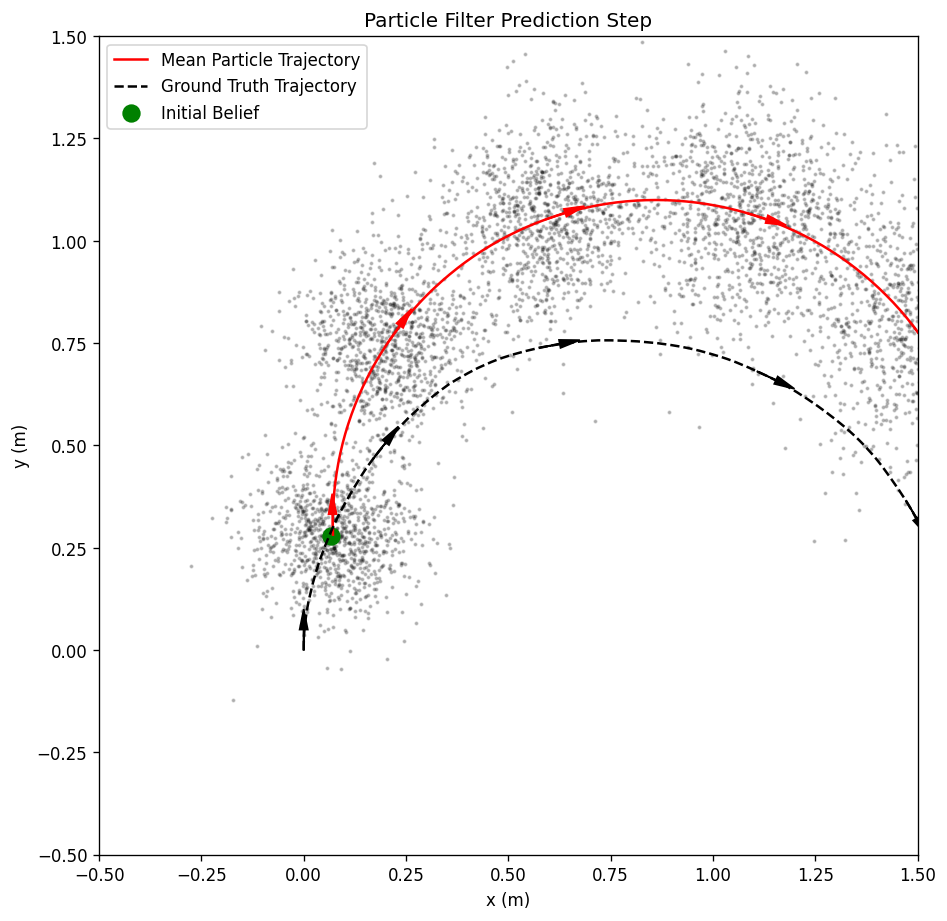

In [39]:
# Part 1: Implement only the prediction step of the particle filter
# Without incorporating the measurement for belief update
num_particles = 1000

particles = np.zeros((num_timesteps, num_particles, 3))
# Initialize particles with the initial belief
particles[0] = np.random.multivariate_normal(
    mean=initial_belief,
    cov=initial_belief_cov,
    size=num_particles
)

# Ground Truth Trajectory
ground_truth_trajectory = np.zeros((num_timesteps, 3))
ground_truth_trajectory[0] = initial_state

belief = initial_belief
for t in range(1, num_timesteps):
    # Update true trajecory (with noise)
    ground_truth_trajectory[t] = dynamics(
        ground_truth_trajectory[t-1],
        add_noise_to_control(U),
        dt
    )
    # Update each particle
    for p in range(num_particles):
        particles[t, p] = predict(particles[t-1, p], add_noise_to_control(U))
# Calculate the mean and covariance of the particles
mean_particles = np.mean(particles, axis=1)
cov_particles = np.cov(particles.reshape(num_timesteps, -1), rowvar=False)

# Visualize the particles and the ground truth trajectory
fig, ax = plt.subplots(figsize=(8, 8), dpi=120, tight_layout=True)

# Plot every 20th timestep
for t in range(0, num_timesteps, 20):
    ax.scatter(particles[t, :, 0], particles[t, :, 1], s=2, color='k', alpha=0.2)

# Plot mean particle trajectory
ax.plot(mean_particles[:, 0], mean_particles[:, 1], color='r', label='Mean Particle Trajectory')
# Draw the arrow indicating the direction of the mean particle trajectory
for t in range(0, num_timesteps, 20):
    ax.arrow(mean_particles[t, 0], mean_particles[t, 1],
             np.cos(mean_particles[t, 2]) * 0.05,
             np.sin(mean_particles[t, 2]) * 0.05,
             head_width=0.02, head_length=0.05, fc='r', ec='r')

# Plot ground truth trajectory
ax.plot(ground_truth_trajectory[:, 0], ground_truth_trajectory[:, 1], color='k', linestyle='--', label='Ground Truth Trajectory')
# Draw the arrow indicating the direction of the ground truth trajectory
for t in range(0, num_timesteps, 20):
    ax.arrow(ground_truth_trajectory[t, 0], ground_truth_trajectory[t, 1],
             np.cos(ground_truth_trajectory[t, 2]) * 0.05,
             np.sin(ground_truth_trajectory[t, 2]) * 0.05,
             head_width=0.02, head_length=0.05, fc='k', ec='k')

# Plot initial belief
ax.scatter(initial_belief[0], initial_belief[1], s=100, color='g', marker='o', label='Initial Belief')
ax.set_title('Particle Filter Prediction Step')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.5, 1.5)
ax.set_aspect('equal')
ax.legend()
plt.savefig('particle_filter_prediction.png', dpi=120)
plt.show()

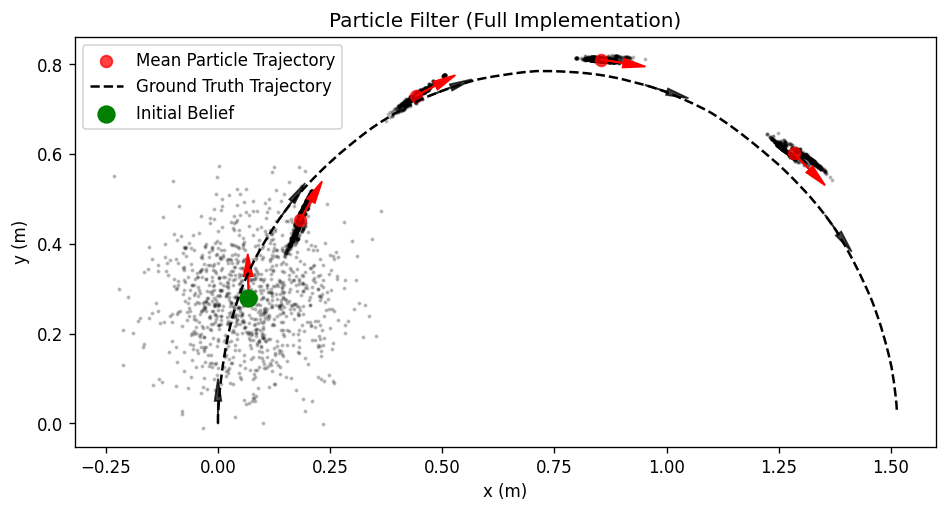

In [ ]:
# Part 2: Implement the full particle filter with resampling
num_particles = 1000

particles = np.zeros((num_timesteps, num_particles, 3))
# Initialize particles with the initial belief
particles[0] = np.random.multivariate_normal(
    mean=initial_belief,
    cov=initial_belief_cov,
    size=num_particles
)

# Ground Truth Trajectory
ground_truth_trajectory = np.zeros((num_timesteps, 3))
ground_truth_trajectory[0] = initial_state

belief = initial_belief
for t in range(1, num_timesteps):
    # Update true trajecory (with noise)
    ground_truth_trajectory[t] = dynamics(
        ground_truth_trajectory[t-1],
        add_noise_to_control(U),
        dt
    )
    # Update each particle
    for p in range(num_particles):
        particles[t, p] = predict(particles[t-1, p], add_noise_to_control(U))
    # Measurement model
    measurement = measurement_model(ground_truth_trajectory[t])
    # Calculate weights based on the measurement
    weights = np.zeros(num_particles)
    for p in range(num_particles):
        # Calculate the likelihood of the measurement given the particle state
        # Gaussian likelihood function
        error_sq = (measurement - particles[t, p])**2
        weights[p] = np.exp(-0.5 * np.sum(
            error_sq / np.diag(measurement_noise_cov)
        ))
    # If weights are (basically) zero, reset to uniform distribution
    # Avoids division by zero in normalization
    if np.sum(weights) < 1e-10:
        weights = np.ones(num_particles) / num_particles
    else:
        # Normalize weights
        weights /= np.sum(weights)
    effective_sample_size = 1.0 / np.sum(weights**2)
    if effective_sample_size < num_particles / 2:
        # Resample particles based on weights
        particles[t] = resample(particles[t], weights)
    else:
        particles[t] = particles[t-1]  # Keep the same particles if resampling is not needed
    # Update belief based on the resampled particles
    belief = np.mean(particles[t], axis=0)
    
# Use the average of the particles as the estimated state
mean_particles = np.mean(particles, axis=1)

# Visualize the particles and the ground truth trajectory
fig, ax = plt.subplots(figsize=(8, 8), dpi=120, tight_layout=True)

# Plot every 20th timestep
for t in range(0, num_timesteps, 20):
    ax.scatter(particles[t, :, 0], particles[t, :, 1], s=2, color='k', alpha=0.2)

# Plot mean particle trajectory
for t in range(0, num_timesteps, 20):
    ax.scatter(mean_particles[t, 0], mean_particles[t, 1], s=50, color='r', alpha=0.75, label='Mean Particle Trajectory' if t == 0 else "")
    # Draw the arrow indicating the direction of the mean particle trajectory
    ax.arrow(mean_particles[t, 0], mean_particles[t, 1],
             np.cos(mean_particles[t, 2]) * 0.05,
             np.sin(mean_particles[t, 2]) * 0.05,
             head_width=0.02, head_length=0.05, fc='r', ec='r')

# Plot ground truth trajectory
ax.plot(ground_truth_trajectory[:, 0], ground_truth_trajectory[:, 1], color='k', linestyle='--', label='Ground Truth Trajectory')
# Draw the arrow indicating the direction of the ground truth trajectory
for t in range(0, num_timesteps, 20):
    ax.arrow(ground_truth_trajectory[t, 0], ground_truth_trajectory[t, 1],
             np.cos(ground_truth_trajectory[t, 2]) * 0.05,
             np.sin(ground_truth_trajectory[t, 2]) * 0.05,
             head_width=0.015, head_length=0.05, fc='k', ec='k', alpha=0.75)

# Plot initial belief
ax.scatter(initial_belief[0], initial_belief[1], s=100, color='g', marker='o', label='Initial Belief')
ax.set_title('Particle Filter (Full Implementation)')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_aspect('equal')
ax.legend()
plt.savefig('particle_filter.png', dpi=120)
plt.show()